## Lindgren, Eric
## 970222-1954

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import scipy.optimize as opt
from scipy.stats import norm
from scipy.stats import cauchy

# Not really needed, but nicer plots
import seaborn as sns
sns.set()
sns.set_context("talk")

# Problem 1:Coin tossing

In [2]:
# sample code from demo-BayesianBasics
def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

def print_uniform_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for a uniform prior. Note that this means alpha=beta=1.
    """
    median, mean, cred68, cred95 = dist_stuff(stats.beta(1+heads,1+N-heads))
    return {"median": median,
            "cred95":cred95}    


A uniform prior is just a constant, which means that it can be incorporated into our normalization. Thus, it won't affect our prior. Our posterior will therefore be our likelihood for procuring j heads in n tosses, up to a normalization factor. This means that we can directly update our posterior by skewing our prior. (Stämmer inte, men hur tänka??)

In [3]:
def count_heads(raw_data, n):
    heads = 0
    for i in range(n):
        if raw_data[i]:
            heads += 1
    return heads

# Read data
f = open('cointosses.dat', 'r')
contents = f.read()
# Split data on newline
raw_data = [int(s) for s in contents.split('\n')[1:-1]]  # Ignore header part, and last row which is a blank ''
# 0 = tails, 1 = heads.
# Extract mean and 95% DOB intervals from the first 8/64/512/4096 tosses.
toss_data = {
    "8": {},
    "64": {},
    "512": {},
    "4096": {},
}
# Assume uniform prior for the probability to of obtaining heads in a single toss. 
# A uniform prior is a beta distribution with alpha=beta=1


# Iterate throgh data and calculate the desired results:
for case in toss_data:
    N = int(case)
    n_heads = count_heads(raw_data, N)
    data = print_uniform_prior_measures(N, n_heads)
    toss_data[case]["data"] = data
# Print the result
print("First number is median, the other is pdf at median")
display(toss_data)

First number is median, the other is pdf at median


{'8': {'data': {'median': [0.28623666802278264, 2.7300869308004185],
   'cred95': (0.07485463141969184, 0.600093573716312)}},
 '64': {'data': {'median': [0.5153054836399436, 6.46057700856088],
   'cred95': (0.3954424614284132, 0.6339902241537905)}},
 '512': {'data': {'median': [0.519480506317825, 18.09424235130088],
   'cred95': (0.47625086380002707, 0.5625162246793547)}},
 '4096': {'data': {'median': [0.5290432798737352, 51.1603477960835],
   'cred95': (0.5137451432009227, 0.5443051209871588)}}}

# Problem 2: Straight line fitting

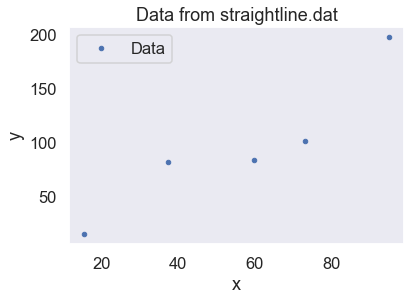

In [4]:
# Read data
def read_file(file):
    f = open(file, 'r')
    contents = f.read()
    raw_data = [s.split(' ') for s in contents.split('\n')[1:-1]]  # Ignore header
    x = np.zeros((len(raw_data),1))
    y = np.zeros((len(raw_data),1))
    for i in range(len(raw_data)):
        x[i] = float(raw_data[i][0])
        y[i] = float(raw_data[i][1])
    return x,y

file = 'straightline.dat'
x, y = read_file(file)

# Plot the data
fig, ax = plt.subplots()
ax.plot(x,y, 'b.', label="Data")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
ax.legend()
plt.title(f"Data from {file}")


sigma = 50  # Define the error

## Study a linear model, with parameters $m$ and $b$. 

Assume our errors in our measurement data to be normally distributed with fixed error. This means that the probability for acquiring data point $d_i$ as a function of $\theta$ will be given as: 

$$ p(d_i | \theta, I) = p(x_i, y_i |\theta, I) = \frac{1}{\sqrt{2 \pi \sigma^2}}e^{\frac{-(y_i-y_{M}(x_i;\theta))^2}{2 \sigma^2}},$$
Here, our data $d_i$ is the value $y_i$ measured at $x_i$. Thus, we get a Gaussian for $y_i$ centered around it's real value $y_{M}(x_i;\theta)$ with a standard deviation $\sigma$. Note that $\sigma$ is independent of $i$.

The probability to observe all data $D$, the likelihood of $D$, can be written as a product of the probability to measure a single datapoint. The logarithm of this is: 

$$ \log p(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\sigma^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\sigma^2}\right) $$
Here $I$ means all other information about our situation. For instance, it contains the ascertation that a straight line fits our data well. 

We are to maximize the posterior $p(\theta|D,I)$ given two different priors. Since we just want to maximize it, we can utilize the "un-normalized" Bayes theorem: 

$$ p(\theta|D,I) \propto p(D|\theta, I)p(\theta|I) \rightarrow$$
$$ \rightarrow \log(p(\theta|D,I)) = \log(p(D|\theta, I)) + \log((\theta|I)) $$
This is what we want to maximize. 

In [5]:
def log_likelihood(x,y,theta, sigma):
    y_m = np.ones(len(x))*theta[0] + theta[1]*x
    term1 = np.ones((len(x)))*np.log((2*np.pi*sigma**2))
    term2 = (y-y_m)**2/sigma**2
    return -1/2*np.sum(term1+term2)
    
def log_flat_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)
    
def log_posterior(theta, flat_prior, x, y, sigma):
    if flat_prior:
        return log_flat_prior(theta) + log_likelihood(x, y, theta, sigma)
    else: 
        return log_symmetric_prior(theta) + log_likelihood(x,y,theta, sigma)
    
def max_posterior_flat(theta):
    return log_flat_prior(theta) - log_likelihood(x,y,theta, sigma)  # Minimization alghoritm, so invert sign
def max_posterior_symmetric(theta):
    return log_symmetric_prior(theta) - log_likelihood(x,y,theta, sigma)

In [6]:
# Maximize the posterior using scipy.optimize
print(f'Flat: \n{opt.minimize(max_posterior_flat,  [0,0])}')
print()
print(f'Symemtric: \n{opt.minimize(max_posterior_symmetric,  [0,0])}')

Flat: 
      fun: 123.12062267609892
 hess_inv: array([[ 5.14676322e+02, -7.37176522e+00],
       [-7.37176522e+00,  1.30590807e-01]])
      jac: array([9.53674316e-07, 3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 6
     njev: 10
   status: 0
  success: True
        x: array([-14.92321978,   1.97691108])

Symemtric: 
      fun: 120.6428131395787
 hess_inv: array([[ 4.93389102e+02, -7.04432510e+00],
       [-7.04432510e+00,  1.25270139e-01]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([-23.43836694,   2.1283227 ])


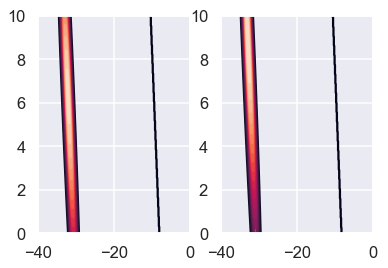

In [12]:
# Plot in theta space
b = np.linspace(-40,0,400)
m = np.linspace(0,10,400)

posterior_map_flat = np.zeros((len(b), len(m))) 
posterior_map_symmetric = np.zeros((len(b), len(m))) 

for i in range(len(b)):
    for j in range(len(m)):
        posterior_map_flat[i,j] = log_posterior([b[i], m[j]], True, x, y, sigma)
        posterior_map_symmetric[i,j] = log_posterior([b[i], m[j]], False, x, y, sigma)

B, M = np.meshgrid(b, m)
fig, ax = plt.subplots(1,2)
ax[0].contour(b, m, np.exp(posterior_map_flat),30)
ax[1].contour(b, m, np.exp(posterior_map_symmetric),30)


Questions:
* The modes are at:
    - Flat: $b=-14.9$, $m=1.98$
    - Symmetric: $b=-23.4$, $m=2.12$
    - Something wrong: I got the same result for both posteriors with very little data. TODO
* The plots can be seen above TODO
* The two parameters are TODO

# Problem 3: Signal and background

In [105]:
# Generate data
# This function generates data according to the statistical model
A_true = 1.
B_true = 2.
width = np.sqrt(5.)   
x_0 = 0

def exact_data(A, B, n_0, x_k, x_0=0., width=np.sqrt(5.)):
    """
    Return the exact signal plus background.  The overall scale is n_0,
    which is determined by how long counts are collected. 
    """
    return n_0 * (A * np.exp(-(x_k - x_0)**2/(2.*width**2)) + B)

Define our own notation for the Poisson distribution, since we're doing a counting experiment: 

$$ p(N|D) = \frac{D^N e^{-D}}{N!} \hspace{10px} \text{ for } N \geq 0$$
N is an integer.

In [143]:
# make a dataset for exploring
def make_dataset(A_true, B_true, width, x_0, databins, delta_x=1, D_max=100):
    """
    Create a data set based on the number of bins (databins), the spacing
    of bins (delta_x), and the maximum we want the exact result to have
    (D_max, this fixes the n_0 parameter).
    
    Return arrays for the x points (xk_pts), the corresponding values of the
    exact signal plus background in those bins (Dk_pts), the measured values
    in those bins (Nk_pts, integers drawn from a Poisson distribution), the 
    maximum extent of the bins (x_max) and n_0.
    """
    
    # set up evenly spaced bins, centered on x_0
    x_max = x_0 + delta_x * (databins-1)/2
    xk_pts = np.arange(-x_max, x_max + delta_x, delta_x, dtype=int)
    
    # scale n_0 so maximum of the "true" signal plus background is D_max
    n_0 = D_max / (A_true + B_true)  
    Dk_pts = exact_data(A_true, B_true, n_0, xk_pts, width=width)
    
    # sample for each k to determine the measured N_k
    Nk_pts = [stats.poisson.rvs(mu=Dk) for Dk in Dk_pts]
    
    return xk_pts, Dk_pts, Nk_pts, x_max, n_0

### Task 1: Plot data

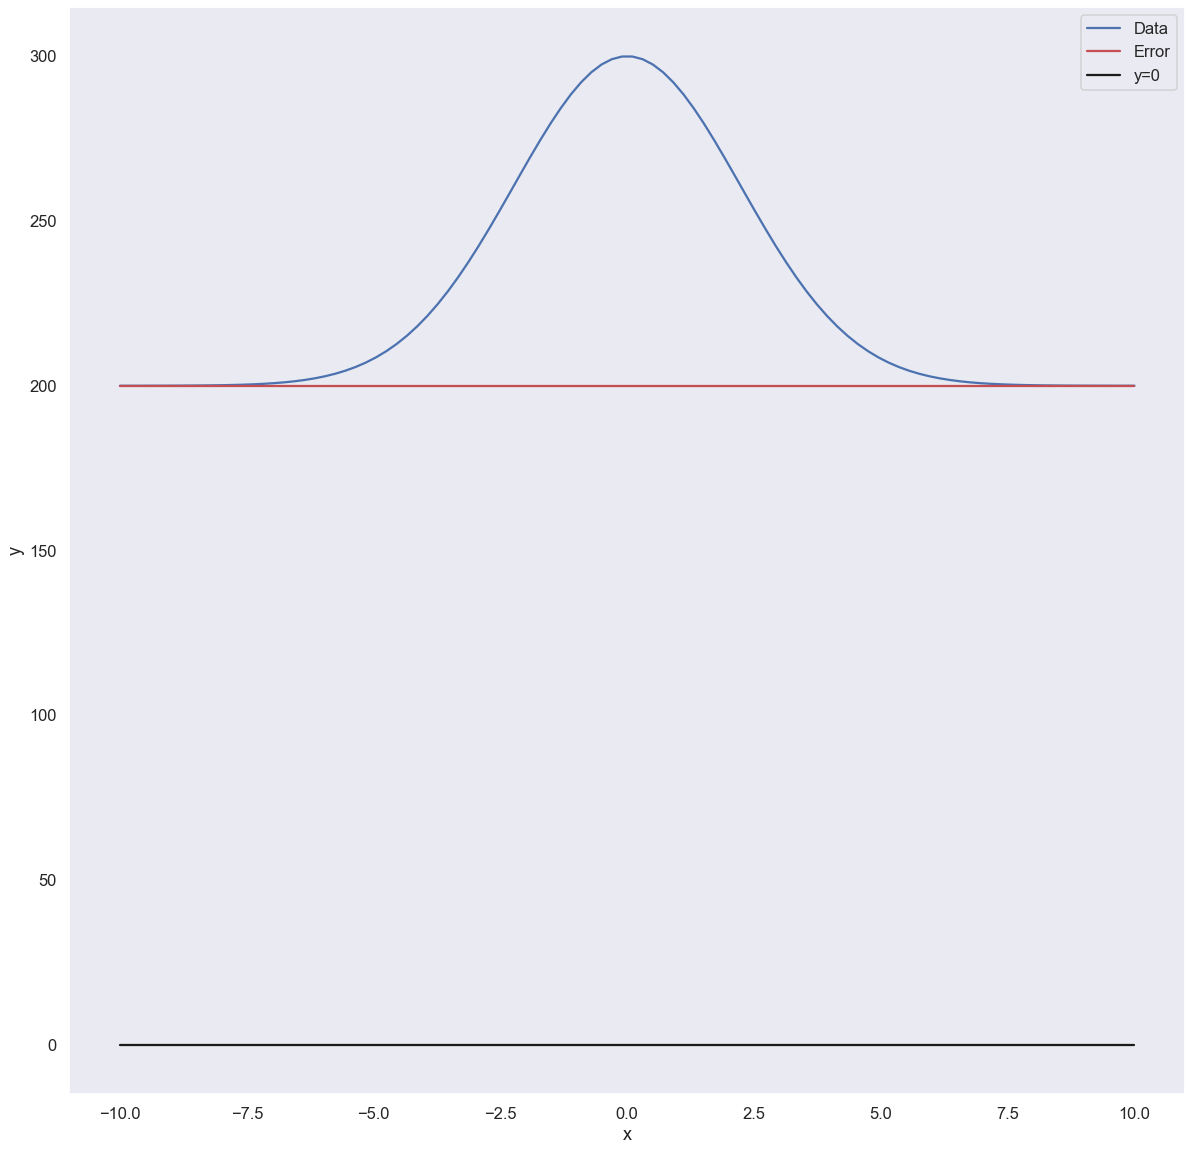

In [144]:
# Plot the data
n_0 = 100 # Set scale to 1
x = np.linspace(-10,10, 100)
data = [exact_data(A_true, B_true, n_0, xi, x_0, width) for xi in x]

real_noise = np.ones((len(x),1))*B_true*n_0

fig, ax = plt.subplots()
ax.plot(x, data, 'b', label='Data')
ax.plot(x, real_noise, 'r', label='Error')
ax.plot(x, np.zeros((len(x),1)), 'k', label="y=0")
#ax.fill_between(x, 0, B_true, label='Error')
ax.grid()
plt.ylabel("y")
plt.xlabel("x")
plt.legend()

### Task 2: Plot data from different counting experiments

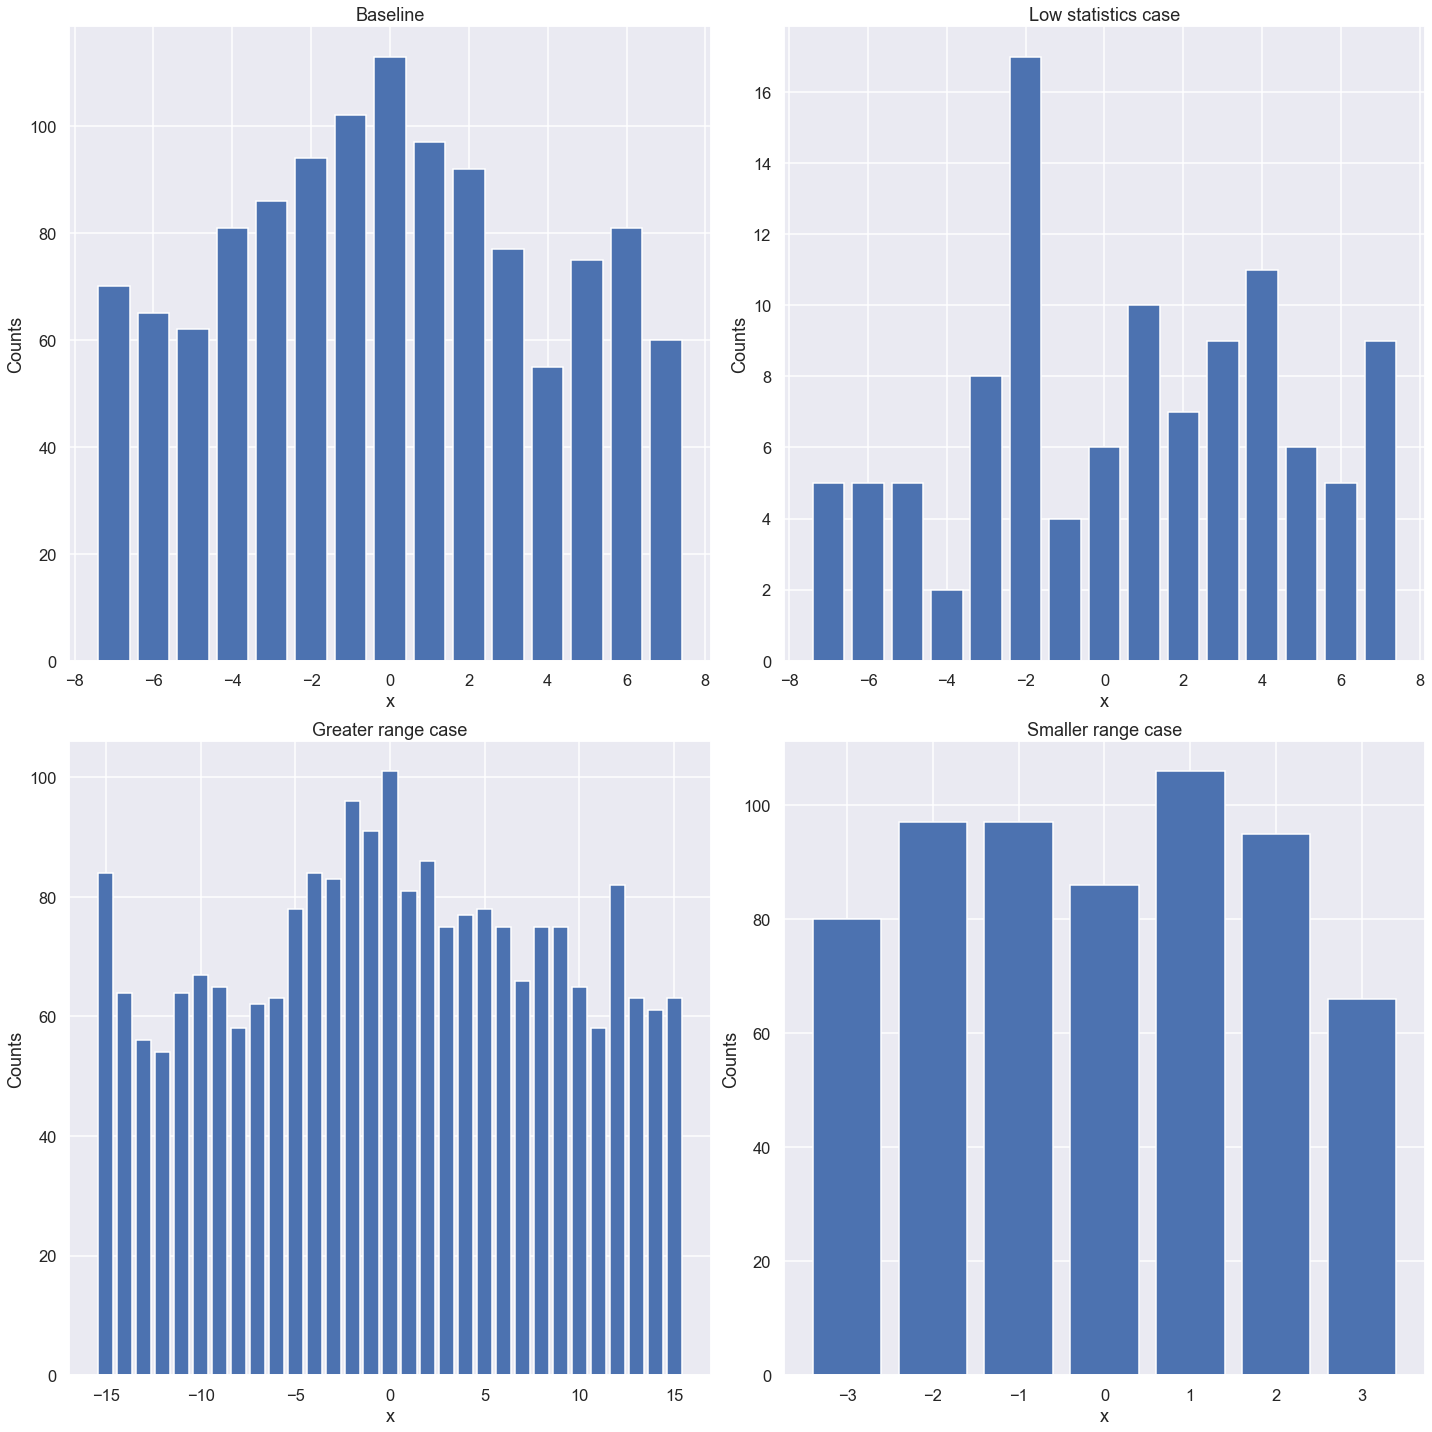

In [145]:
# Define the different experiments
experiments = {
    "Baseline": {
        "databins": 15,
        "D_max": 100
    },
    "Low statistics case": {
        "databins": 15,
        "D_max": 10
    },
    "Greater range case": {
        "databins": 31,
        "D_max": 100
    },
    "Smaller range case": {
        "databins": 7,
        "D_max": 100
    }
}

# Define figure
fig, axs = plt.subplots(2,2)
axs = axs.reshape(4,)

for i, experiment in enumerate(experiments):
    databins = experiments[experiment]["databins"]
    D_max = experiments[experiment]["D_max"]
    # Fixate the bin width to 1, this is 
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, x_0, databins, 1, D_max)
    # Save results
    experiments[experiment]["xk_pts"] = xk_pts
    experiments[experiment]["Dk_pts"] = Dk_pts
    experiments[experiment]["Nk_pts"] = Nk_pts
    experiments[experiment]["x_max"] = x_max
    experiments[experiment]["n_0"] = n_0
    # Plot them
    axs[i].bar(xk_pts,Nk_pts)
    axs[i].set_title(experiment)
    axs[i].set_xlabel("x")
    axs[i].set_ylabel("Counts")

plt.tight_layout()

# TODO: What is expection? Is it D_max?

### Task 3: Implement functions for log likelihood and uniform log prior

We have done our experiments. Now we can use that information to construct our likelihood, since we can determine what the probability for generating that data is according to our Poisson distribution.

In [146]:
def log_uniform_prior(A,B):
    if (A > 0 and A < 5) and (B > 0 and B < 5):
        return 0 # log(1)
    else:
        return -np.inf # log(0)

    
def log_likelihood(A, B, n_0, Nk, xk):
    # We know the data to be distributed according to a Poisson
    D = exact_data(a,b, n_0, xk)
    p_D = np.sum(np.log(stats.poisson.pmf(Nk, mu=D)))
    return p_D


def log_posterior(A,B, n_0, Nk, xk):
    return log_uniform_prior(A,B) + log_likelihood(A,B, n_0, Nk, xk)

(100, 100)
(100, 100)


C:\Miniconda3\envs\physics\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


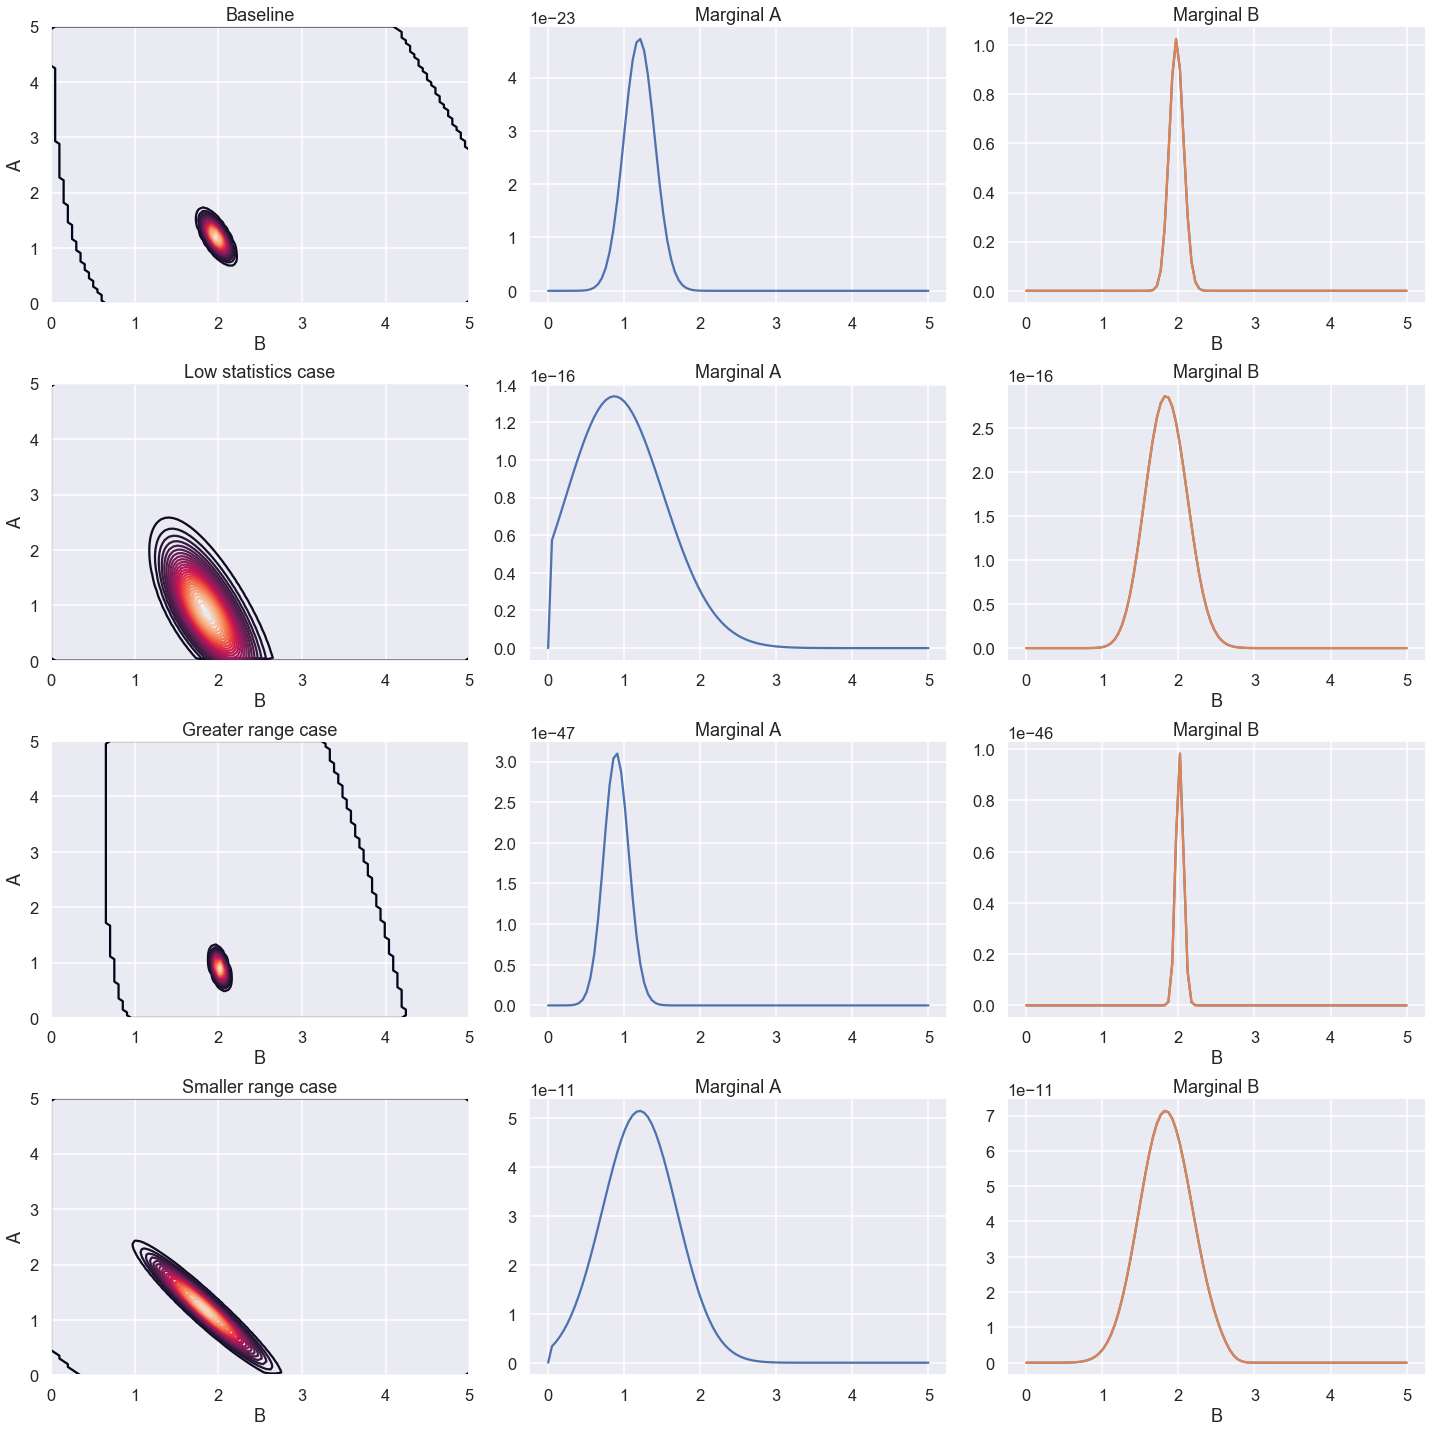

In [147]:
# Evaluate log-posterior on a grid
A = np.linspace(0, 5, 100)
B = np.linspace(0, 5, 100) 

# Create a meshgrid of A and B
aa, bb = np.meshgrid(A,B)
print(aa.shape)
print(bb.shape)

# Create a new dict with same keys as the different experiments
results = {}
for key in experiments:
    results[key] = {
        "log_posterior": np.zeros((len(A), len(B))),
        "marginalA": np.zeros((len(A),1)),
        "marginalB": np.zeros((len(B),1))
    }

# Iterate through all of the points for A and B, and evaluate the log
# posterior for all of the experiments for that set of points:
for i, a in enumerate(A):
    for j, b in enumerate(B):
        for idx, experiment in enumerate(experiments):
            n_0 = experiments[experiment]["n_0"]
            Nk = experiments[experiment]["Nk_pts"]
            xk = experiments[experiment]["xk_pts"]
            Dk = experiments[experiment]["Dk_pts"] 
            log_post = log_posterior(a, b, n_0, Nk, xk)
            results[experiment]["log_posterior"][i,j] = log_post

# Marginal distributions
for experiment in experiments:
    log_post = results[experiment]["log_posterior"]
    for i in range(len(A)):
        results[experiment]["marginalA"][i] = np.sum(np.exp(log_post)[i,:]) 
    for j in range(len(B)):
        results[experiment]["marginalB"][j] = np.sum(np.exp(log_post)[:,j]) 
        
# plot
fig, ax = plt.subplots(4,3)
# Plot contours
for idx, experiment in enumerate(results): 
    log_post = results[experiment]["log_posterior"]
    margA = results[experiment]["marginalA"]
    margB = results[experiment]["marginalB"]
    # Countor plot of joint pdf
    cfset = ax[idx, 0].contour(B, A, np.exp(log_post), 30)
    ax[idx,0].set_xlabel("B")
    ax[idx,0].set_ylabel("A")
    # Plot A pdf
    ax[idx, 1].plot(A, margA)
    ax[idx, 1].set_title("Marginal A")
    ax[idx, 2].set_xlabel("A")
    # Plot B pdf
    ax[idx, 2].plot(B, margB)
    ax[idx, 2].plot(B, margB)
    ax[idx, 2].set_title("Marginal B")
    ax[idx, 2].set_xlabel("B")
    
    ax[idx,0].set_title(experiment)
plt.tight_layout()
plt.rcParams["figure.figsize"]=20,20

### Questions to ponder
* S/N anticorrelated
* 1
* 2
* 3

# Problem 4

(100,)


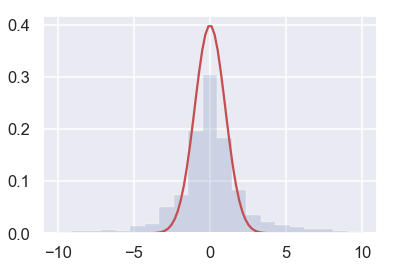

In [14]:
# Draw a number of random samples from the standard Cauchy
r = cauchy.rvs(size=1000)
fig, ax = plt.subplots()
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2, 
         range=(-10,10),bins=21);
# Plot a normal distribution for comparison 
def norm_dist(x, mu, sigma):
    fun = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-np.ones((len(x)))*mu)**2/(2*sigma**2))
    return fun
x = np.linspace(-10,10,100)

mu = 0
sigma = 1
print(norm_dist(x, mu, sigma).shape)
ax.plot(x, norm_dist(x, mu, sigma), 'r')


The pdf is thus quite similar to a normal distribution. This is probably due to the law of large numbers.

This gives us our pdf for the posterior position. Now we are to make this callable, where we return this pdf at the desired points x. 

In [36]:
def posterior_function(x):
    # Deliberately unnormalized
    return 1/(1+x**2)

def normalized_posterior_function(x):
    fun = 1/(1+x**2)
    # Numerically integrate function. Since pdf, should be 1.
    norm = np.trapz(fun,x)
    return fun/norm

In [16]:
def sampler(posterior_func, no_of_samples=4, start_position=.5, 
            proposal_width=1., plot=False):
    # starting parameter position
    current_position = start_position
    
    samples = [current_position]
    for i in range(no_of_samples):
        if (i%500 == 0):
            print(f'sample {i+1} out of {no_of_samples}')
        # suggest new position
        proposed_position = scipy.stats.norm(current_position, proposal_width).rvs(1)[0]
        # Compute posteriors of current and proposed position 
        p_current = posterior_function(current_position)
        p_proposal = posterior_function(proposed_position)
        # Acceptance probability
        # Note that this part will be modified in the Metropolis-Hastings algorithm 
        # for which we also consider asymmetric proposal distributions
        p_accept = p_proposal / p_current
        
        # Accept proposal?
        accept = p_accept > scipy.stats.uniform(0,1).rvs(1)
        # Visualization
        if plot:
            assert no_of_samples < 11, "Too many samples for visualization"
            plot_proposal(posterior_func, current_position, p_current, 
                          proposed_position, p_proposal, accept, samples, i)
        
        # Possibly update position
        if accept:
            current_position = proposed_position
        samples.append(current_position)
        
    return np.array(samples)


In [17]:
# Function to display
def plot_proposal(posterior_func, current_position, p_current, 
                  proposed_position, p_proposal, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-5, 5, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot posterior
    ax1.plot(x, posterior_func(x))
    ax1.plot([current_position] * 2, [0, p_current], marker='o', color='b')
    ax1.plot([proposed_position] * 2, [0, p_proposal], marker='o', color=color)
    ax1.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', \
            title='current: posterior(mu=%.2f) = %.2f\nproposal: posterior(mu=%.2f) = %.2f' \
            % (current_position, p_current, proposed_position, p_proposal))
    
    if accepted:
        trace.append(proposed_position)
    else:
        trace.append(current_position)
        
    # Posterior histogram
    ax2.plot(x, normalized_posterior_function(x)) # properly normalized
    sns.distplot(trace, kde=False, norm_hist=True, ax=ax2)
    ax2.axvline(current_position, color='b', linestyle='--', 
                label='current position')
    ax2.axvline(proposed_position, color=color, linestyle='--', 
                label='proposed position')
    ax2.annotate("", xy=(proposed_position, 0.2), xytext=(current_position, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))

    
    ax3.plot(trace)
    ax3.set(xlabel='iteration', ylabel='position', title='trace')
    plt.tight_layout()

sample 1 out of 8


C:\Users\ericl\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


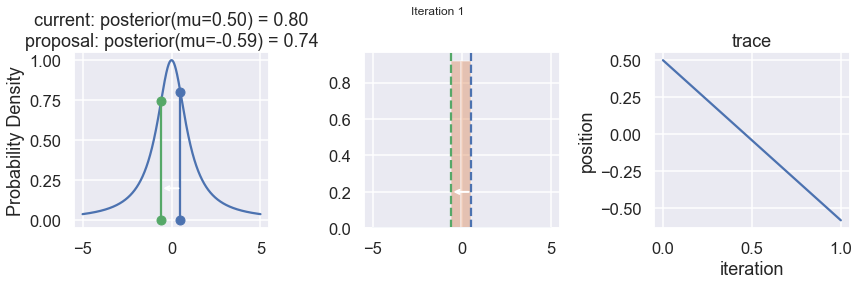

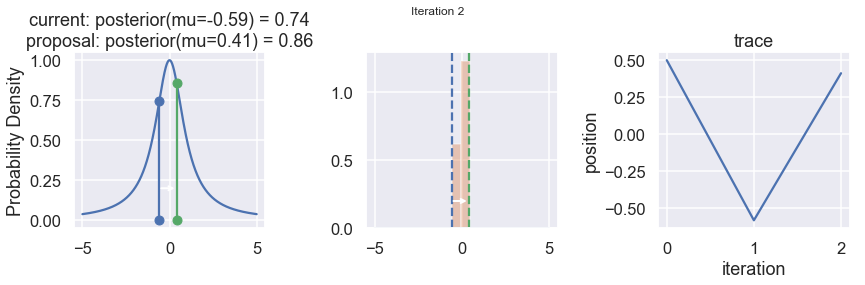

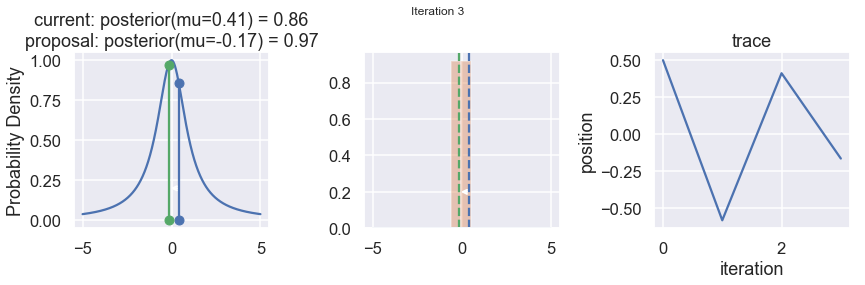

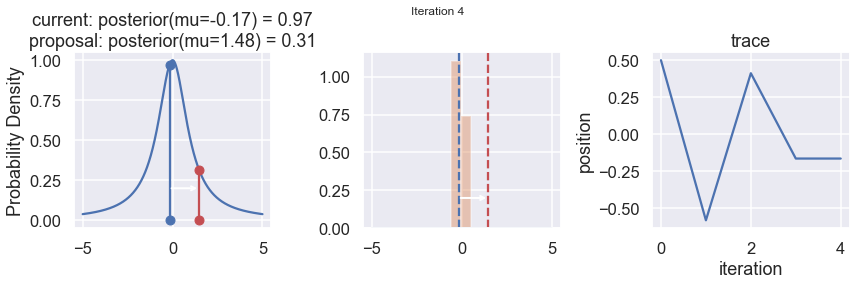

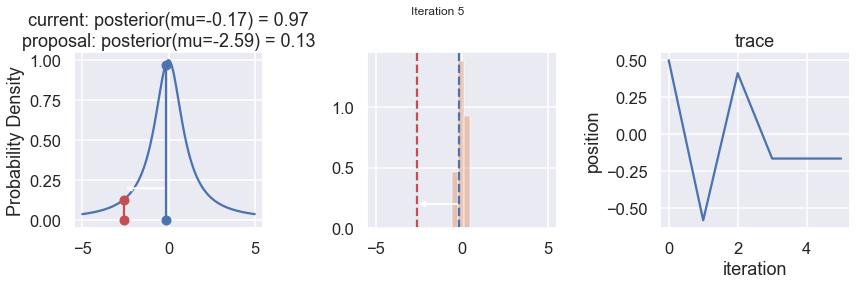

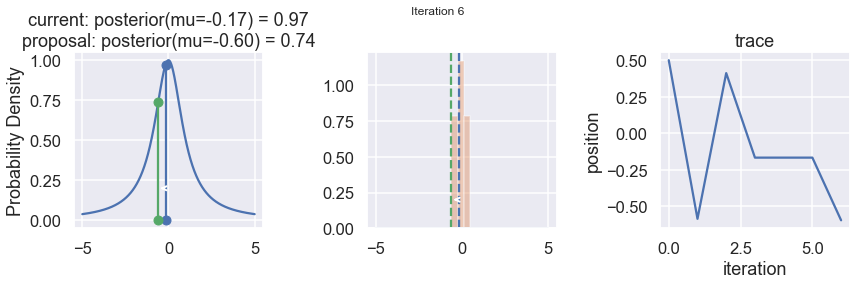

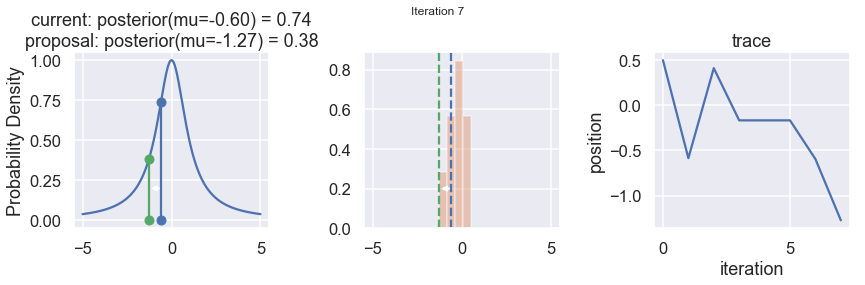

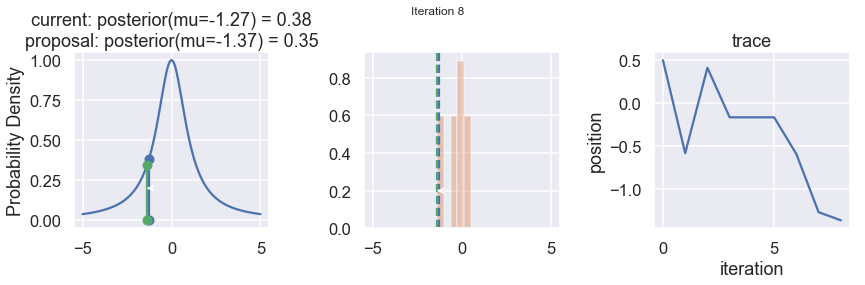

In [18]:
np.random.seed(123)
samples = sampler(posterior_function, no_of_samples=8, start_position=.5, proposal_width=1., plot=True);

### Final task


In [20]:
# get n=100000 samples
n=100000
samples = sampler(posterior_function, no_of_samples=n, start_position=.5, proposal_width=1., plot=False);
print("Done")

sample 1 out of 1000
sample 501 out of 1000
Done


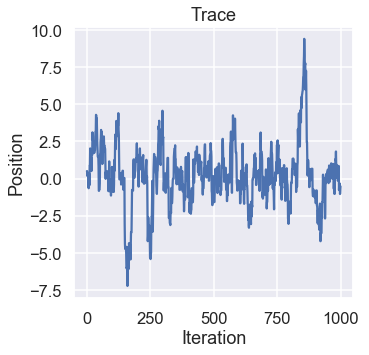

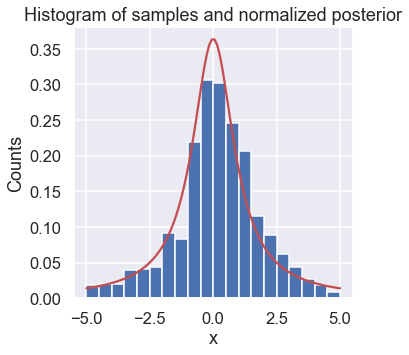

<Figure size 1440x720 with 0 Axes>

In [39]:
x = np.linspace(-5,5,100)
fig, ax0 = plt.subplots()
# Plot the trace
ax0.plot(samples)
ax0.set_title('Trace')
ax0.set_xlabel('Iteration')
ax0.set_ylabel('Position')

fig, ax1 = plt.subplots()
plt.figure(figsize=(20,10))
# Plot a histogram of the trace, and then our normalized posterior
ax1.hist(samples, 20, (x[0],x[-1]), density=1)
ax1.set_title('Histogram of samples and normalized posterior')
ax1.set_ylabel('Counts')
ax1.set_xlabel('x')
ax1.plot(x, normalized_posterior_function(x), 'r')

plt.tight_layout()
plt.rcParams["figure.figsize"]=5,5

# Increase axis size:
#for i in range(len(ax)):
#    box = ax[i].get_position()
#    ax[i].set_position([box.x0, box.y0, box.width * 2 , box.height * 3])




False
